**Note:-This is a sample solution for the project. Projects will NOT be graded on the basis of how well the submission matches this sample solution. Projects will be graded on the basis of the rubric only.**

# Bank Churn prediction
 
### **Context**:

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### **Objective**:

Let us consider you are working as Data scientist with the  bank and you need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### **Data Dictionary**:

The case study is from an open-source dataset from Kaggle.The dataset contains 10,000 sample points with 14 distinct features as follows:

CustomerId: Unique ID which is assigned to each customer

Surname: Last name of the customer
 
CreditScore: It defines the credit history of the customer.
  
Geography: A customer’s location 
   
Gender: It defines the Gender of the customer
   
Age: Age of the customer 
    
Tenure: Number of years for which the customer has been with the bank

NumOfProducts: refers to the number of products that a customer has purchased through the bank.

Balance: Account balance

HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

EstimatedSalary: Estimated salary 

isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

Exited : whether or not the customer left the bank within six month. It can take two values 

0=No ( Customer did not leave the bank )
1=Yes ( Customer left the bank )

#### Importing libraries  

In [117]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# Library to encode the variables
from sklearn import preprocessing

# To plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# library to import to standardize the data
from sklearn.preprocessing import StandardScaler

# To import different metrics 
from sklearn import metrics
from tensorflow.keras import backend

# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

# importing different functions to build models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

# importing GridSearch CV
from sklearn.model_selection import GridSearchCV

# importing roc_curve to plot
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# importing SMOTE
from imblearn.over_sampling import SMOTE

# importing metrics
from sklearn import metrics
import random

#Importing classback API
from tensorflow.keras import callbacks

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Read the dataset

In [4]:
ds = pd.read_csv("bank.csv")

In [5]:
ds.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


#### Drop the columns which are unique for all users like IDs

In [6]:
#RowNumber , CustomerId and Surname are unique hence dropping it
ds = ds.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


* As you can see, there are no null values in any of the column of this dataset

### Exploratory Data Analysis

Here our main interest is to get an understanding as to how the given attributes relate to the 'Exit' status.

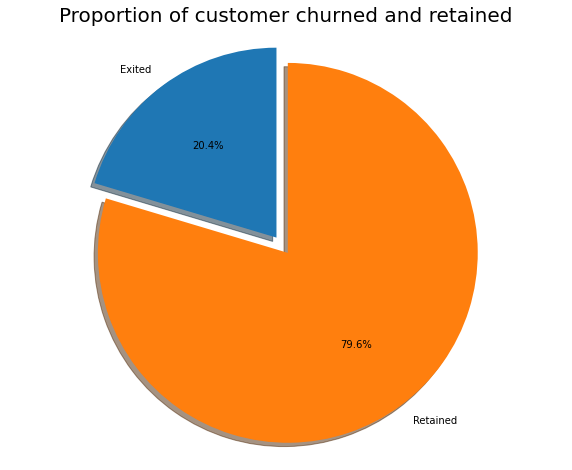

In [8]:
labels = 'Exited', 'Retained'
sizes = [ds.Exited[ds['Exited']==1].count(), ds.Exited[ds['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

* About 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained

###  Target variable Vs Categorical variables

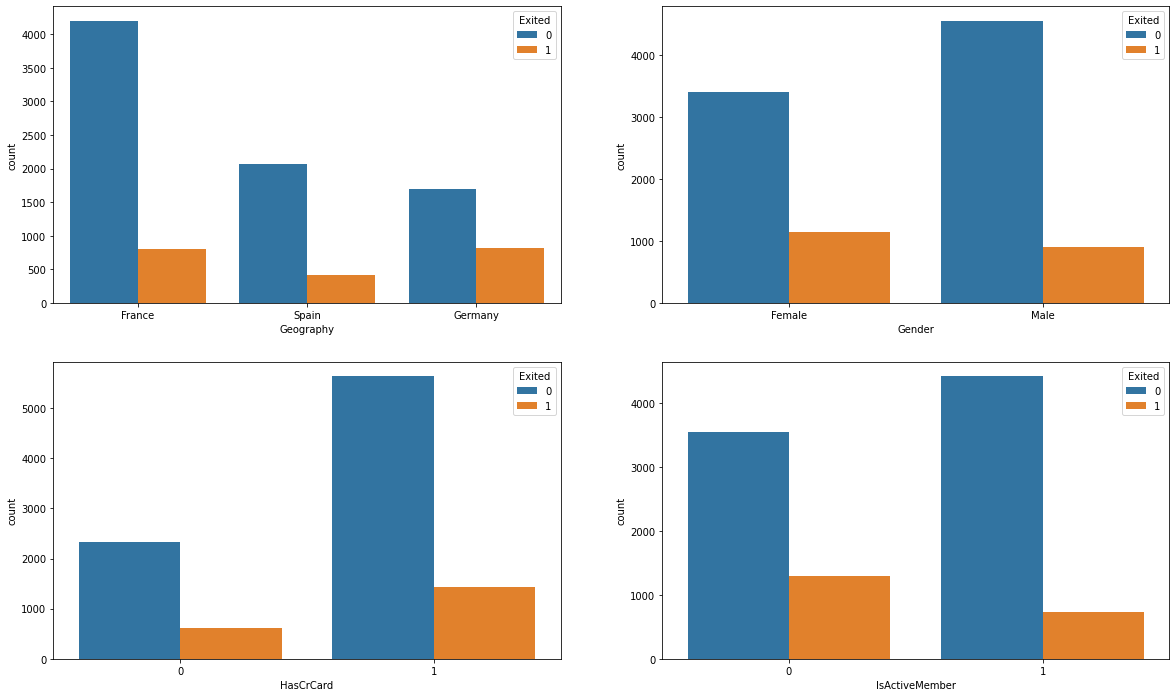

In [9]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = ds, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = ds, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = ds, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = ds, ax=axarr[1][1]);

We note the following:

*  Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.

* The proportion of female customers churning is also greater than that of male customers
Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.


* Unsurprisingly the inactive members have a greater churn. 
Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn

### Target variable Vs Numerical variables 

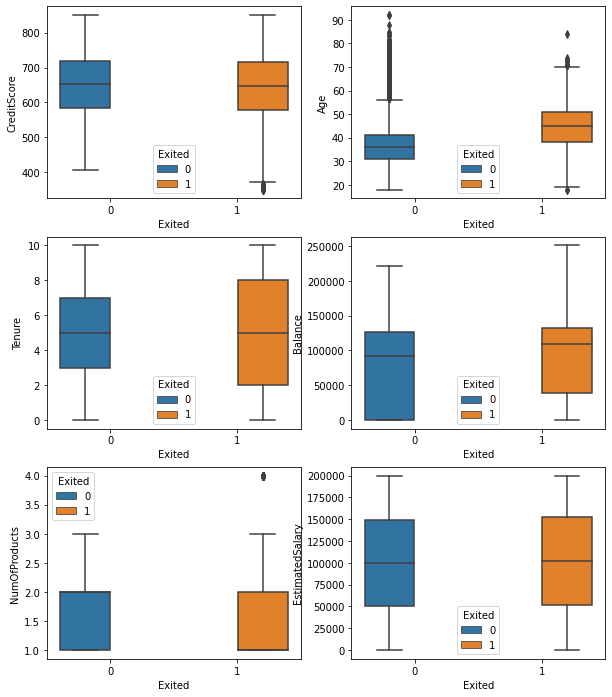

In [12]:
fig, axarr = plt.subplots(3, 2, figsize=(10, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = ds , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[2][1]);

We note the following:

* There is no significant difference in the credit score distribution between retained and churned customers. The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review its target market or review the strategy for retention between the different age groups.

- Worryingly, the bank is losing customers with significant bank balances which are likely to hit their available capital for lending.

- Neither the product nor the salary has a significant effect on the likelihood to churn.

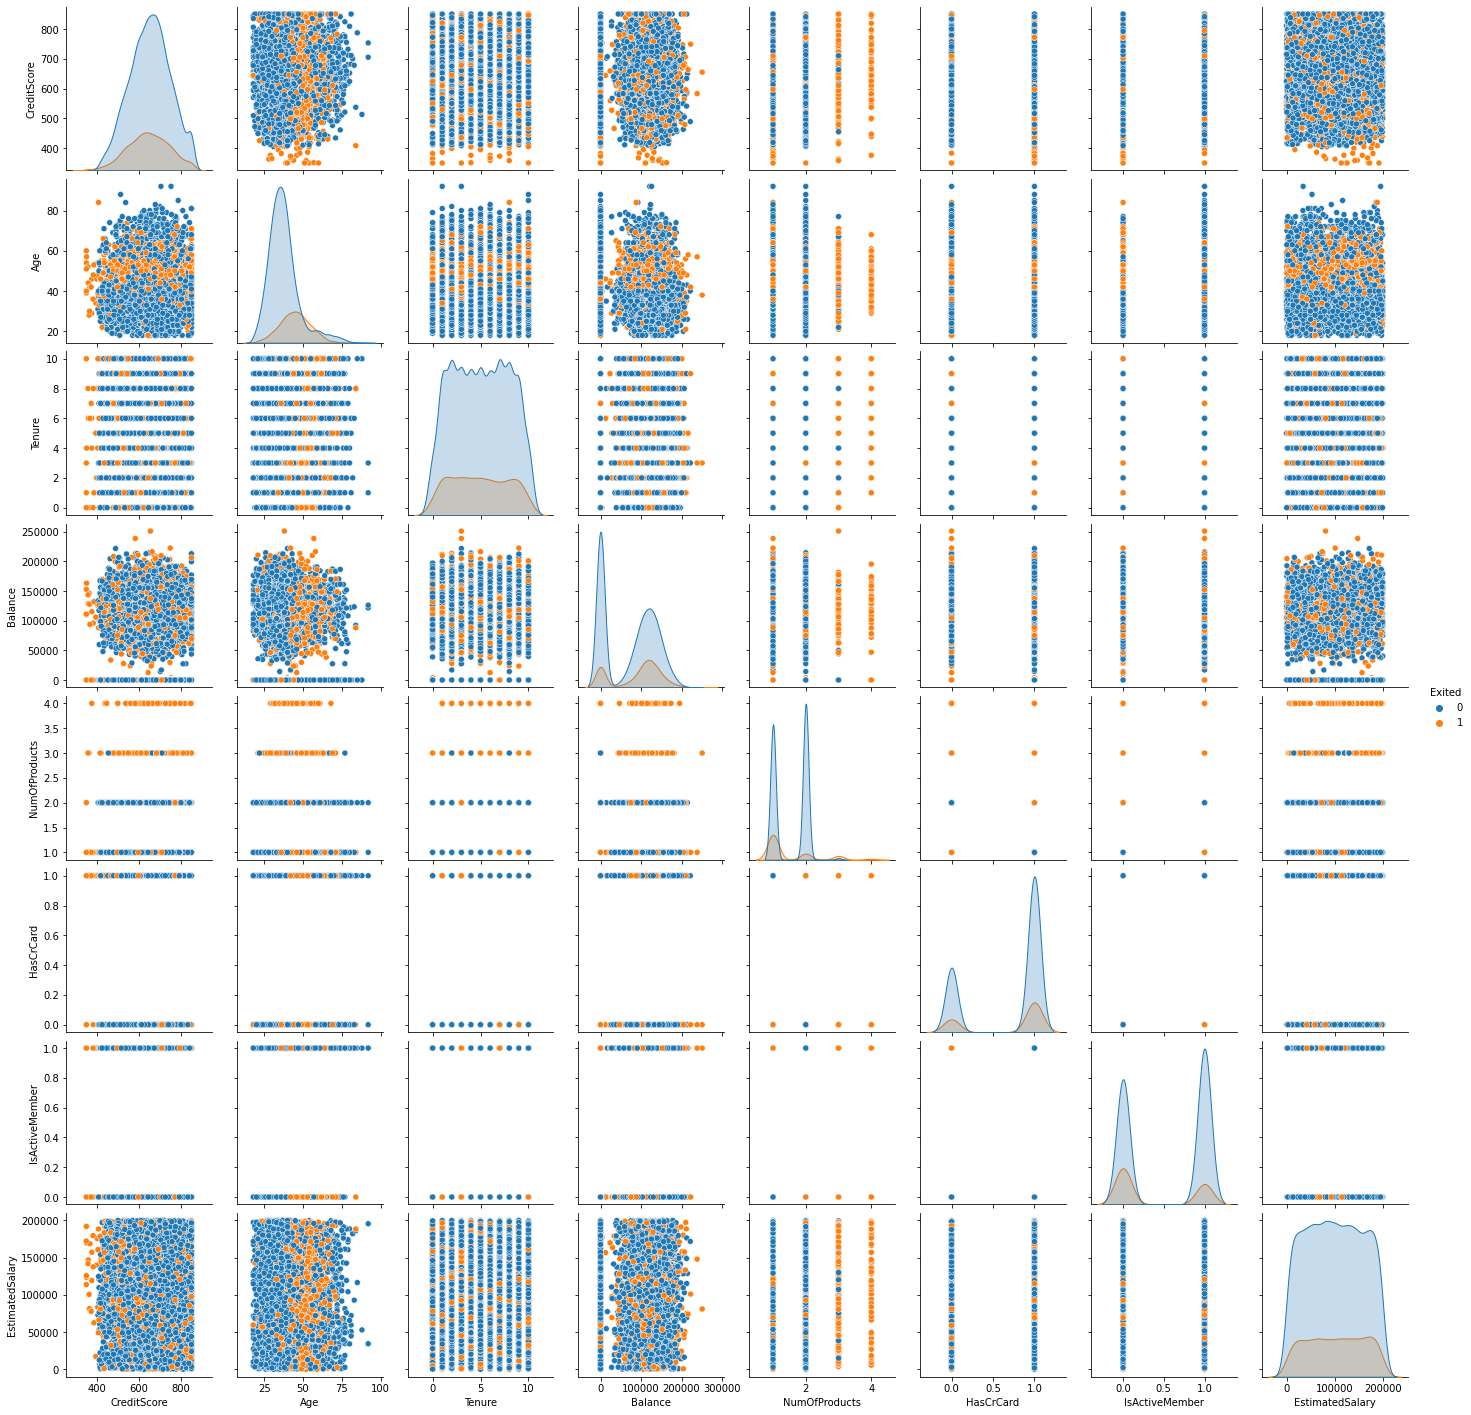

In [13]:
sns.pairplot(ds, diag_kind = 'kde', hue = 'Exited');

**Insights :** 
* No correlation observed between the  columns

* Exited Customers seem to be distributed across all Credit Scores

* Lot of Customers customers aged between 40-60 seem to have exited the bank 

* Lot of  customers with 3-4 products seem to have exited the bank

* Customers with or without credit cards seem to have exited the bank

* Lot of  customers who are non active members seem to have exited the bank

* Customers across all Estimated Salaries seem to have exited the bank uniformly

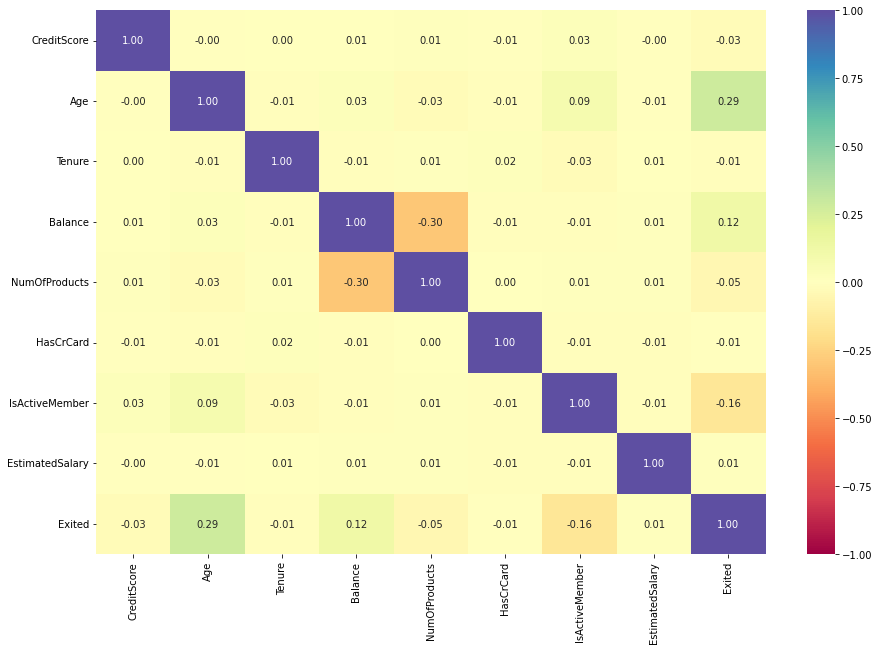

In [16]:
plt.figure(figsize = (15, 10))
sns.heatmap(ds.corr(method = "pearson"), annot = True, fmt = '0.2f', cmap = "Spectral", vmin = -1, vmax = 1);

**Insights :** None of the columns are strongly corelated with each other. There is no multicollinearity.

#### Distinguish the feature and target set

In [23]:
X = ds.drop(['Exited'],axis=1) # Credit Score through Estimated Salary
y = ds[['Exited']] # Exited

In [21]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [24]:
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


#### Divide the data set into Train,Val and test sets

In [185]:
# Splitting the dataset into the Training and Testing set.

X_large, X_test, y_large, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y,shuffle = True)

In [186]:
# Splitting the dataset into the Training and Testing set.

X_train, X_val, y_train, y_val = train_test_split(X_large,y_large, test_size = 0.2, random_state = 42,stratify=y_large, shuffle = True)

#### Categorical Encoding

In [187]:
# Encoding Geography variable
X_train = pd.get_dummies(X_train, columns=["Geography","Gender"],drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Geography","Gender"],drop_first=True)
X_val = pd.get_dummies(X_val, columns=["Geography","Gender"],drop_first=True)

#### Normalize the train,val and test data

Since all the numerical values are on a different scale, so we will be scaling all the numerical values to bring them to the same scale. 

In [188]:
sc=StandardScaler()
temp = sc.fit(X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_test[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_test[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_val[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_val[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])

In [29]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3006,0.988678,0.572685,-1.384980,0.610704,1,1,0,1.566070,0,0,0
5735,-0.683985,0.477619,-0.355056,-1.237347,2,0,1,0.036348,0,1,0
5652,0.410474,-0.948376,1.361485,-1.237347,2,0,0,1.745403,0,0,0
26,1.081604,-0.282911,-1.041672,0.962063,1,1,1,1.228816,1,0,1
3596,-0.085130,-0.282911,-1.728288,1.144427,1,0,0,-0.764748,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3239,1.143554,-1.899039,0.331561,-1.237347,2,1,0,-0.770604,0,1,0
413,0.431124,0.192420,1.361485,1.679777,3,1,1,1.541056,1,0,0
5787,0.802827,-1.233575,-0.355056,0.326308,2,1,0,-1.052407,1,0,1
860,0.162672,0.382553,1.018177,1.820697,1,1,0,-0.037323,0,0,1


## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting a customer is exiting  and the customer  is not exiting
* Predicting a customer is not exiting and  customer is  exiting

### Which case is more important? 
* Predicting that customer is not exiting but he/she is exiting. It might cause loss to the banks because due to wrong identification bank will not be able to take any initiative for those sensitive customers. 

### How to reduce this loss i.e need to reduce False Negative?
* Bank would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the bank can retain their customers.

#### Initialize & build the model

In [88]:
backend.clear_session()
# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [89]:
# Initializing the ANN
classifier = Sequential()

# Adding the input layer with 64 neurons with relu as activation function with input of 11 variables
classifier.add(Dense(activation = 'relu', input_dim = 11, units = 64))

# Adding 2nd hidden layer with 32 neurons
classifier.add(Dense(32, activation='relu'))

# Adding the output layer 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
classifier.add(Dense(1, activation = 'sigmoid')) 

In [43]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00


In [90]:
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import ModelCheckpoint

In [91]:
# Compile the model with SGD optimizer and binary cross entropy as loss with accuracy as metrics

metrics = ["accuracy", Precision(), Recall(), F1Score(num_classes = 1)]

mc_cb = ModelCheckpoint("model_1", monitor = "val_recall", save_best_only = True, verbose = 2, mode = "max")

classifier.compile(optimizer='SGD', loss='binary_crossentropy', metrics=metrics)

In [92]:
# Model summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Fitting the model 
history=classifier.fit(X_train, y_train,           
          validation_data=(X_val,y_val),
          epochs=100,
          batch_size=32,
          callbacks = [mc_cb])

Epoch 1/100
198/200 [============================>.] - ETA: 0s - loss: 0.5215 - accuracy: 0.7877 - precision: 0.2255 - recall: 0.0178 - f1_score: 0.3381
Epoch 1: val_recall improved from -inf to 0.00000, saving model to model_1
200/200 [==============================] - 39s 191ms/step - loss: 0.5214 - accuracy: 0.7875 - precision: 0.2255 - recall: 0.0176 - f1_score: 0.3385 - val_loss: 0.4830 - val_accuracy: 0.7962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.3385
Epoch 2/100
184/200 [==========================>...] - ETA: 0s - loss: 0.4762 - accuracy: 0.7948 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.3402
Epoch 2: val_recall improved from 0.00000 to 0.00307, saving model to model_1
200/200 [==============================] - 1s 6ms/step - loss: 0.4739 - accuracy: 0.7964 - precision: 0.6667 - recall: 0.0015 - f1_score: 0.3385 - val_loss: 0.4583 - val_accuracy: 0.7969 - val_precision: 1.0000 - val_recall: 0.0031 - val_f1_score: 0.3385
Epoch 3/100


In [95]:
from tensorflow.keras.models import load_model

classifier = load_model("model_1")

63/63 [==============================] - 1s 4ms/step - loss: 0.3614 - accuracy: 0.8550 - precision: 0.7127 - recall: 0.4816 - f1_score: 0.3382


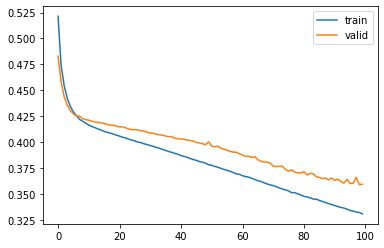

In [96]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = classifier.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.3614 - accuracy: 0.8550 - precision: 0.7127 - recall: 0.4816 - f1_score: 0.3382


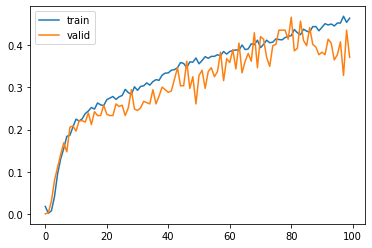

In [97]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['recall'])
plt.plot(hist['val_recall'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = classifier.evaluate(X_test, y_test)

Validation and training *Loss* is decreasing but it seems like it is overfitting. There is no noise in the training. Sometimes, the Loss function fluctuates a lot during training which makes the convergence slow. These fluctuations are due to the noisy updates in the parameters. Let's check other metrics

#### Let's Plot confusion matrix 

In [98]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

50/50 [==============================] - 0s 1ms/step


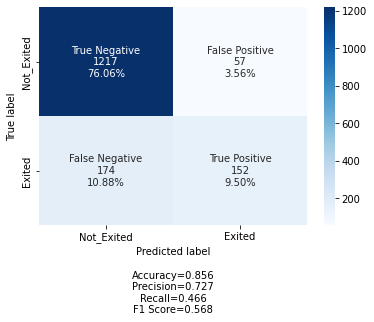

In [99]:
#Calculating the confusion matrix 
y_pred1=classifier.predict(X_val)

#Let's predict using default threshold
y_pred1 = (y_pred1 > 0.5)
cm2=confusion_matrix(y_val, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

As you can see, the above model has good accuracy and precision but have poor recall. There can be two reasons as follows:

1) **Imbalanced dataset:** As you have seen in the EDA, This dataset is imbalanced and it contains more examples belong to non_exited class (0).

2) **Decision Threshold** As you see this dataset is imbalance. Therefore, we can use ROC-AUC to find the optimal threshold and use the same for prediction.

Lets try to tune the decision threshold, apply SMOTE to balance the dataset and configure some other hyperparameters accordingly 

##### Since the above model has some noise in validation loss, let's Change the Optimizer from SGD to Adam

In [101]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [102]:
def create_model():
      #Initializing the neural network
      model = Sequential()
      #Adding the input layer with 64 neurons and relu as activation function
      model.add(Dense(64,activation='relu',input_dim = X_train.shape[1]))
      # Adding the first hidden layer with 32 neurons with relu as activation functions
      model.add(Dense(32,activation='relu'))
      # Adding the output layer
      model.add(Dense(1, activation = 'sigmoid'))
      #Compiling the ANN with Adam optimizer 
      optimizer = tf.keras.optimizers.Adam(0.001)
      # Complining the model with binary cross entropy as loss function and accuracy as metrics
      model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=metrics)
      return model

In [103]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [104]:
#Fitting the ANN with batch_size = 32 and 100 epochs 
mc_cb = ModelCheckpoint("model_1", monitor = "val_recall", save_best_only = True, verbose = 2, mode = "max")

history = model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=100,verbose=1, callbacks=[mc_cb])

Epoch 1/100
192/200 [===========================>..] - ETA: 0s - loss: 0.4543 - accuracy: 0.7982 - precision: 0.6338 - recall: 0.1540 - f1_score: 0.3396
Epoch 1: val_recall did not improve from 0.46626
200/200 [==============================] - 3s 5ms/step - loss: 0.4512 - accuracy: 0.7998 - precision: 0.6350 - recall: 0.1558 - f1_score: 0.3385 - val_loss: 0.4334 - val_accuracy: 0.8106 - val_precision: 0.6620 - val_recall: 0.1442 - val_f1_score: 0.3385
Epoch 2/100
192/200 [===========================>..] - ETA: 0s - loss: 0.4108 - accuracy: 0.8275 - precision: 0.7034 - recall: 0.2652 - f1_score: 0.3386
Epoch 2: val_recall did not improve from 0.46626
200/200 [==============================] - 1s 4ms/step - loss: 0.4101 - accuracy: 0.8283 - precision: 0.7079 - recall: 0.2676 - f1_score: 0.3385 - val_loss: 0.4179 - val_accuracy: 0.8263 - val_precision: 0.6905 - val_recall: 0.2669 - val_f1_score: 0.3385
Epoch 3/100
193/200 [===========================>..] - ETA: 0s - loss: 0.3949 - accura

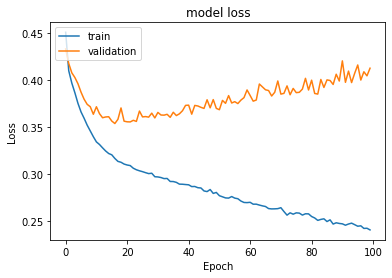

In [105]:
#Plotting Train Loss vs Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

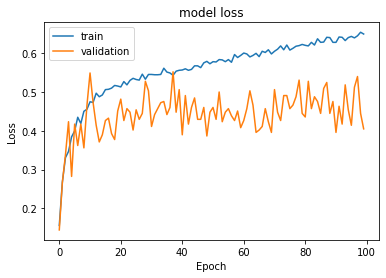

In [106]:
#Plotting Train Loss vs Validation Loss
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [107]:
model = load_model("model_1")

As you can see from the above image, this model is severely overfitting. Deep learning models are very sensitive to overfitting due to a large number of parameters. We need to find the optimal point where the training should be stopped.

The best solution for the above problem is **Early stopping**.

**Early stopping:** 

During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade or no improvement (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped after certain iterations. The model at the time that training is stopped is then used and is known to have good generalization performance.

This procedure is called “early stopping” and is perhaps one of the oldest and most widely used forms of neural network regularization.

In [110]:
 # Defining Early stopping
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
mc_cb = ModelCheckpoint("model_1", monitor = "val_recall", save_best_only = True, verbose = 2, mode = "max")
model_e = create_model()

# Fitting the ANN with batch_size = 32 and 100 epochs 
history_e = model_e.fit(X_train,y_train,batch_size=32,epochs=100,verbose=1,validation_data=(X_val,y_val),callbacks=[es_cb, mc_cb])

Epoch 1/100
198/200 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8011 - precision: 0.6859 - recall: 0.1467 - f1_score: 0.3394
Epoch 1: val_recall improved from -inf to 0.14110, saving model to model_1
200/200 [==============================] - 3s 8ms/step - loss: 0.4478 - accuracy: 0.8022 - precision: 0.6866 - recall: 0.1479 - f1_score: 0.3385 - val_loss: 0.4297 - val_accuracy: 0.8100 - val_precision: 0.6571 - val_recall: 0.1411 - val_f1_score: 0.3385
Epoch 2/100
188/200 [===========================>..] - ETA: 0s - loss: 0.4121 - accuracy: 0.8246 - precision: 0.6934 - recall: 0.2475 - f1_score: 0.3381
Epoch 2: val_recall improved from 0.14110 to 0.26687, saving model to model_1
200/200 [==============================] - 1s 7ms/step - loss: 0.4119 - accuracy: 0.8245 - precision: 0.6980 - recall: 0.2446 - f1_score: 0.3385 - val_loss: 0.4145 - val_accuracy: 0.8263 - val_precision: 0.6905 - val_recall: 0.2669 - val_f1_score: 0.3385
Epoch 3/100
199/200 [==========

Lets plot the loss function again

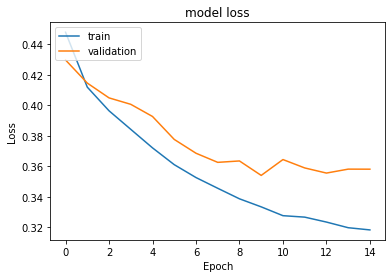

In [111]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_e.history['loss'])
plt.plot(history_e.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

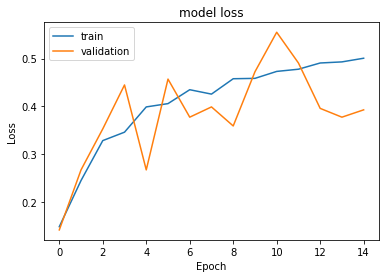

In [112]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_e.history['recall'])
plt.plot(history_e.history['val_recall'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [113]:
model_e = load_model("model_1")

As you can see from the above graph, training is stopped at the appropriate epoch because, after that, the loss function started to increase. Therefore, Early stopping prevents overfitting.

**Let's tune the threshold using ROC-AUC**


There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

Sensitivity = TruePositive / (TruePositive + FalseNegative)


Specificity = TrueNegative / (FalsePositive + TrueNegative)

Where:

Sensitivity = True Positive Rate

Specificity = 1 – False Positive Rate

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

G-Mean = sqrt(Sensitivity * Specificity)

One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.

200/200 [==============================] - 0s 1ms/step
Best Threshold=0.311683, G-Mean=0.798


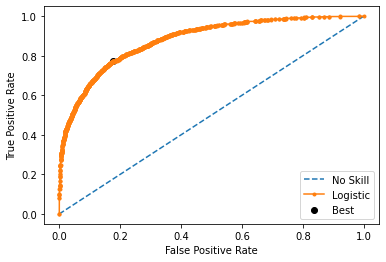

In [114]:
# predict probabilities
yhat = model_e.predict(X_train)

# keep probabilities for the positive outcome only
yhat = yhat[:, 0]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show();

In [115]:
# Predicting the results using best as a threshold
y_pred_e = model_e.predict(X_val)
y_pred_e = (y_pred_e > thresholds[ix])
y_pred_e

50/50 [==============================] - 0s 2ms/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

Accuracy, Precision, Recall, and F1-Scores

In [118]:
# Accuracy as per the classification report 
cr = classification_report(y_val,y_pred_e)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1274
           1       0.49      0.71      0.58       326

    accuracy                           0.79      1600
   macro avg       0.71      0.76      0.72      1600
weighted avg       0.83      0.79      0.81      1600



Printing Confusion matrix

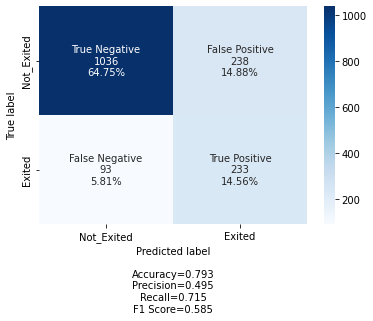

In [119]:
# Calculating the confusion matrix
cm1 = confusion_matrix(y_val, y_pred_e)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

As you can see, the recall of the model is changed but accuracy got decreased. Let's try to decrease the number of neurons in the hidden layer and add dropout to the model since the above model is overfitting.



In [125]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [126]:
#Initializing the neural network
model_3 = Sequential()
#Adding the input layer with 32 neurons and relu as activation function
model_3.add(Dense(32,activation='relu',input_dim = X_train.shape[1]))
# Adding dropout with ratio of 0.2
model_3.add(Dropout(0.2))
# Adding the second hidden layer with 16 neurons with relu as activation functions
model_3.add(Dense(16,activation='relu'))
# Adding dropout with ratio of 0.1
model_3.add(Dropout(0.1))
# Adding the third hidden layer with 8 neurons with relu as activation functions
model_3.add(Dense(8,activation='relu'))
# Adding the output layer
model_3.add(Dense(1, activation = 'sigmoid'))

In [127]:
# Summary of the model
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainabl

In [128]:
# Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy", Precision(), Recall(), F1Score(num_classes = 1)]

# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_3.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = metrics)

In [129]:
#Fitting the ANN with batch_size = 32 and 100 epochs 
mc_cb = ModelCheckpoint("model_1", monitor = "val_recall", save_best_only = True, verbose = 2, mode = "max")

history_3 = model_3.fit(X_train,y_train,batch_size=32,epochs=100,verbose=1,validation_data=(X_val,y_val),callbacks=[es_cb, mc_cb])

Epoch 1/100
198/200 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7576 - precision: 0.2403 - recall: 0.0856 - f1_score: 0.3396
Epoch 1: val_recall improved from -inf to 0.00000, saving model to model_1
200/200 [==============================] - 4s 10ms/step - loss: 0.5123 - accuracy: 0.7588 - precision: 0.2403 - recall: 0.0851 - f1_score: 0.3385 - val_loss: 0.4538 - val_accuracy: 0.7962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.3385
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.4522 - accuracy: 0.7963 - precision: 0.5128 - recall: 0.0462 - f1_score: 0.3391
Epoch 2: val_recall improved from 0.00000 to 0.03681, saving model to model_1
200/200 [==============================] - 2s 8ms/step - loss: 0.4515 - accuracy: 0.7967 - precision: 0.5128 - recall: 0.0460 - f1_score: 0.3385 - val_loss: 0.4376 - val_accuracy: 0.7981 - val_precision: 0.5714 - val_recall: 0.0368 - val_f1_score: 0.3385
Epoch 3/100
197/200 [=

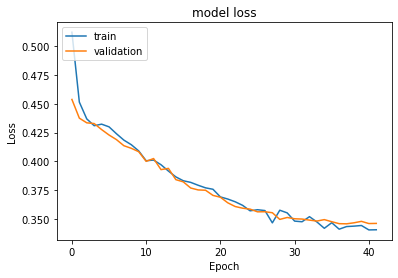

In [130]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

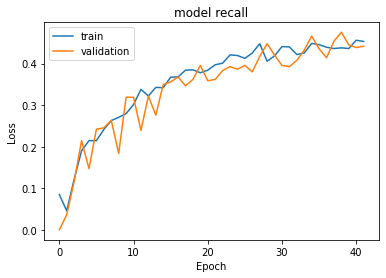

In [131]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['recall'])
plt.plot(history_3.history['val_recall'])
plt.title('model recall')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [132]:
model_3 = load_model("model_1")

From the above plot, we can observe that the train and validation curves are having smooth lines. Reducing the number of neurons and adding dropouts to the model worked, and the problem of overfitting was solved.

200/200 [==============================] - 0s 2ms/step
Best Threshold=0.255004, G-Mean=0.793


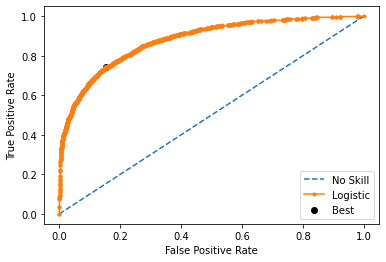

In [133]:
# predict probabilities
yhat = model_3.predict(X_train)

# keep probabilities for the positive outcome only
yhat = yhat[:, 0]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [134]:
# Predicting the results using best as a threshold
y_pred_e = model_3.predict(X_val)
y_pred_3 = (y_pred_e > thresholds[ix])
y_pred_3

50/50 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [136]:
# Accuracy as per the classification report 
cr = classification_report(y_val,y_pred_3)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1274
           1       0.52      0.70      0.60       326

    accuracy                           0.81      1600
   macro avg       0.72      0.77      0.74      1600
weighted avg       0.84      0.81      0.82      1600



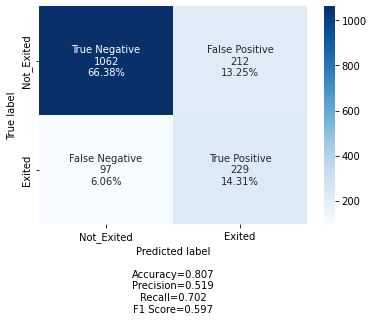

In [137]:
#Calculating the confusion matrix 

cm1=confusion_matrix(y_val,y_pred_3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

From the above confusion matrix, we can observe that the accuracy and recall are the same, but this model is not overfitting like the previous model. Let's try hyperparameter tuning to get a better model and metrics using GridSearchCV.

#### Hyperparameter Optimization

Some important parameters to look out for while optimizing neural networks are:

-Type of architecture

-Number of Layers

-Number of Neurons in a layer

-Regularization parameters

-Learning Rate

-Type of optimization / backpropagation technique to use

-Dropout rate

-Weight sharing

In [146]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [147]:
def create_model_v2(dropout_rate=0.5,lr=0.001,layer_1=64,layer_2=32, metrics = metrics):  
    np.random.seed(1337)
    #Initializing the neural network
    model = Sequential()
    # This adds the input layer (by specifying input dimension)
    model.add(Dense(layer_1,activation='relu',input_dim = X_train.shape[1]))
    #Adding dropout layer
    model.add(Dropout(dropout_rate))
    # # Adding the hidden layer
    # Notice that we do not need to specify input dim. 
    model.add(Dense(layer_2,activation='relu'))
    # # Adding the output layer
    # Notice that we do not need to specify input dim. 
    # we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
    # We use the sigmoid because we want probability outcomes
    model.add(Dense(1, activation='sigmoid'))

    # Adding Adam initializer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    #compile model
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = metrics)
    return model

##### Using Grid search

We are using grid search to optimize two hyperparameters called **batch size, epochs** due to the limited time. But you can optimize the other hyperparameters as mentioned above

In [141]:
! pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
from scikeras.wrappers import KerasClassifier

keras_estimator = KerasClassifier(build_fn=create_model_v2, verbose=1)

type(keras_estimator)

scikeras.wrappers.KerasClassifier

In [143]:
# define the grid search parameters
param_grid = {
    'batch_size':[40, 64, 128],
    "lr":[0.01,0.001,0.1]}


kfold_splits = 3
# Applying GridSearchCV
grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1,
                    scoring = "recall")

In [ ]:
## Fitting Grid model
grid_result = grid.fit(X_train, y_train,validation_data = (X_val,y_val),verbose=1) 

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# Printing mean 
means = grid_result.cv_results_['mean_test_score']
# Printing standard deviation
stds = grid_result.cv_results_['std_test_score']
# Printing best parameters
params = grid_result.cv_results_['params']

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   11.6s finished


160/160 [==============================] - 1s 2ms/step - loss: 0.4542 - accuracy: 0.8017 - val_loss: 0.4312 - val_accuracy: 0.8056
Best: 0.819219 using {'batch_size': 40, 'lr': 0.01}


* Best model is with the following configuration:  ( It may vary each time code runs )

**Result of Grid Search**

{'batch_size': 40, 'learning_rate":0.01}

**Heuristic for Hyperparameters**

optimizer="adam", layer1_units=64, layer2_units = 32

## Let's create the final model with above mentioned configuration

In [ ]:
# Creating the model
estimator_v2 = create_model_v2(lr=grid_result.best_params_['lr'])

# Printing model summary
estimator_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                768       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [148]:
! pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.1 MB/s eta 0:00:00


In [157]:
np.array(y_train["Exited"]).reshape(-1, 1)

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [158]:
import keras_tuner

tuner = keras_tuner.BayesianOptimization(
    create_model_v2,
    objective=keras_tuner.Objective("val_recall", direction="max"),
    max_trials=10)

tuner.search(X_train, y_train["Exited"], epochs=30, validation_data=(X_val, y_val["Exited"]))

ValueError: ignored

In [ ]:
## Fitting the model
history_h=estimator_v2.fit(X_train, y_train, epochs=100, batch_size = grid_result.best_params_['batch_size'], verbose=1,validation_data=(X_val,y_val))

Epoch 1/100
160/160 [==============================] - 1s 2ms/step - loss: 0.4538 - accuracy: 0.8000 - val_loss: 0.4319 - val_accuracy: 0.8188
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.8200 - val_loss: 0.4148 - val_accuracy: 0.8288
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4159 - accuracy: 0.8278 - val_loss: 0.4085 - val_accuracy: 0.8300
Epoch 4/100
160/160 [==============================] - 0s 1ms/step - loss: 0.4098 - accuracy: 0.8306 - val_loss: 0.4054 - val_accuracy: 0.8381
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8323 - val_loss: 0.3966 - val_accuracy: 0.8319
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 0.3989 - accuracy: 0.8347 - val_loss: 0.3908 - val_accuracy: 0.8356
Epoch 7/100
160/160 [==============================] - 0s 2ms/step - loss: 0.3878 - accuracy: 0.8408 - val_loss: 0.3694 - val_accuracy: 0.8438

Epoch 58/100
160/160 [==============================] - 0s 1ms/step - loss: 0.3429 - accuracy: 0.8581 - val_loss: 0.3488 - val_accuracy: 0.8562
Epoch 59/100
160/160 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8577 - val_loss: 0.3490 - val_accuracy: 0.8581
Epoch 60/100
160/160 [==============================] - 0s 2ms/step - loss: 0.3403 - accuracy: 0.8591 - val_loss: 0.3641 - val_accuracy: 0.8450
Epoch 61/100
160/160 [==============================] - 0s 1ms/step - loss: 0.3458 - accuracy: 0.8591 - val_loss: 0.3477 - val_accuracy: 0.8600
Epoch 62/100
160/160 [==============================] - 0s 1ms/step - loss: 0.3400 - accuracy: 0.8603 - val_loss: 0.3548 - val_accuracy: 0.8581
Epoch 63/100
160/160 [==============================] - 0s 1ms/step - loss: 0.3432 - accuracy: 0.8603 - val_loss: 0.3600 - val_accuracy: 0.8562
Epoch 64/100
160/160 [==============================] - 0s 1ms/step - loss: 0.3387 - accuracy: 0.8583 - val_loss: 0.3666 - val_accuracy:

Plotting the validation and training loss

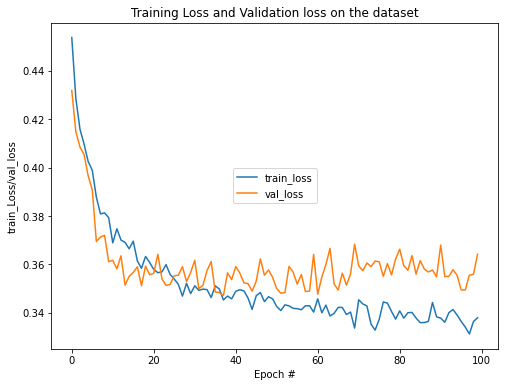

In [ ]:
N =100
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), history_h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_h.history["val_loss"], label="val_loss")

plt.title("Training Loss and Validation loss on the dataset")
plt.xlabel("Epoch #")
plt.ylabel("train_Loss/val_loss")
plt.legend(loc="center")
plt.show()

As you can seen , the above model's validation curve does not have high slope which means it has  not decreased much. Let's check other metrics to understand how this model works 

##### Tuning the threshold

Best Threshold=0.188937, G-Mean=0.802


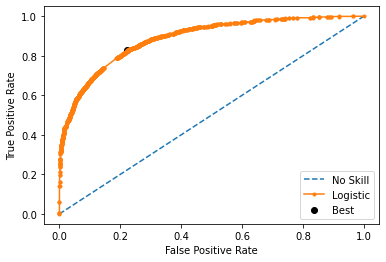

In [ ]:
# predict probabilities
yhat = estimator_v2.predict(X_train)

# keep probabilities for the positive outcome only
yhat = yhat[:, 0]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

#### Predict the results using  the best  threshold

In [ ]:
# pridiction
y_pred_h = estimator_v2.predict(X_val)
print(y_pred_h)

[[0.19784382]
 [0.00262141]
 [0.05754322]
 ...
 [0.19997835]
 [0.54473054]
 [0.5191881 ]]


In [ ]:
# To use the confusion Matrix, we need to convert the probabilities that a customer will leave the bank into the form true or false. 
# So we will use the best cutoff value  to indicate whether they are likely to exit or not.
y_pred_h = (y_pred_h > thresholds[ix])
print(y_pred_h)

[[ True]
 [False]
 [False]
 ...
 [ True]
 [ True]
 [ True]]


In [ ]:
#lets print classification report
cr=metrics.classification_report(y_val,y_pred_h)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1274
           1       0.45      0.76      0.57       326

    accuracy                           0.76      1600
   macro avg       0.69      0.76      0.70      1600
weighted avg       0.83      0.76      0.78      1600



#### Print the  confusion matrix

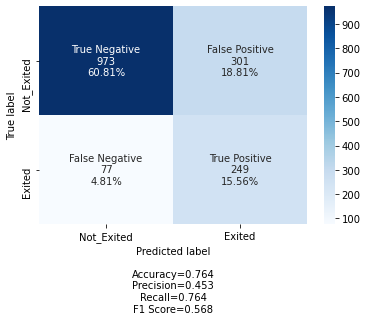

In [ ]:
#Calculating the confusion matrix 
cm_h=confusion_matrix(y_val,y_pred_h)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm_h, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

Hyperparameter tuning is used here  to get a better accuracy but accuracy might differ each time. Other hyperparameters can also be tuned to get a better accuracy. Here, Recall of the model is slighty changed but the accuracy is slightly degraded.





**Let's try to apply SMOTE to balance this dataset and then again apply hyperparamter tuning accordingly.**

In [159]:
sm  = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train) 
print('After UpSampling, the shape of train_X: {}'.format(X_train.shape)) 
print('After UpSampling, the shape of train_y: {} \n'.format(y_train.shape))

After UpSampling, the shape of train_X: (10192, 11)
After UpSampling, the shape of train_y: (10192, 1) 



<AxesSubplot:xlabel='Exited', ylabel='count'>

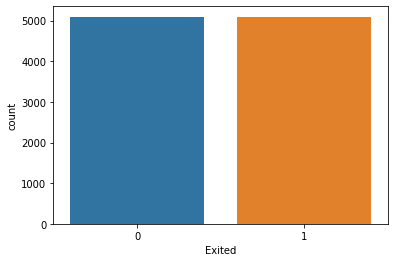

In [160]:
sns.countplot(y_train['Exited'])

As you can see in the graph, Both the class have equal number of examples. Threfore, the datset is balanced now

Let's build a model with the balanced dataset

We will define  the complex model with some dropout layers added between the hidden layers which will help us to prevent overfitting

In [161]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [162]:
#Initializing the model
model_4 = Sequential()
# Adding input layer of 32 neurons with relu as activation function
model_4.add(Dense(32,activation='relu',input_dim = X_train.shape[1]))
# Adding the dropout
model_4.add(Dropout(0.2))
# Adding hidden layer with 16 neurons with relu as activation function
model_4.add(Dense(16,activation='relu'))
# Adding the dropout
model_4.add(Dropout(0.1))
# Adding hidden layer with 8 neurons with relu as activation function
model_4.add(Dense(8,activation='relu'))
# Adding the output layer 
model_4.add(Dense(1, activation = 'sigmoid'))

In [163]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainabl

In [164]:
# Defining Early stopping
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
mc_cb = ModelCheckpoint("model_1", monitor = "val_recall", save_best_only = True, verbose = 2, mode = "max")

# Initializing Adam optimizer
optimizer = tf.keras.optimizers.Adam(0.001)

# Complining the model with binary cross entropy as loss and accuracy as metrics
model_4.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = metrics)

# Fitting the model on train and test with batch_size of 64, epochs of 100 
history_4 = model_4.fit(X_train,y_train,batch_size=64,epochs=100,verbose=1,validation_data = (X_val,y_val), callbacks = [es_cb, mc_cb])

Epoch 1/100
158/160 [============================>.] - ETA: 0s - loss: 0.6436 - accuracy: 0.6329 - precision: 0.6307 - recall: 0.6454 - f1_score: 0.6296
Epoch 1: val_recall improved from -inf to 0.63190, saving model to model_1
160/160 [==============================] - 4s 15ms/step - loss: 0.6432 - accuracy: 0.6333 - precision: 0.6312 - recall: 0.6455 - f1_score: 0.6300 - val_loss: 0.5592 - val_accuracy: 0.7262 - val_precision: 0.3931 - val_recall: 0.6319 - val_f1_score: 0.3385
Epoch 2/100
156/160 [============================>.] - ETA: 0s - loss: 0.5759 - accuracy: 0.7093 - precision: 0.7098 - recall: 0.7089 - f1_score: 0.6669
Epoch 2: val_recall improved from 0.63190 to 0.66871, saving model to model_1
160/160 [==============================] - 2s 10ms/step - loss: 0.5762 - accuracy: 0.7093 - precision: 0.7094 - recall: 0.7090 - f1_score: 0.6667 - val_loss: 0.5494 - val_accuracy: 0.7312 - val_precision: 0.4037 - val_recall: 0.6687 - val_f1_score: 0.3385
Epoch 3/100
153/160 [========

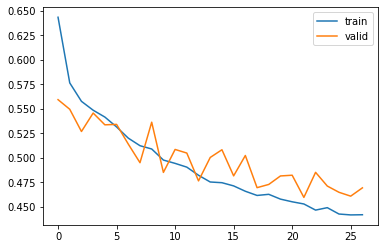

In [166]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history_4.history)
# hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

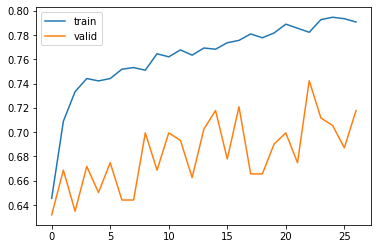

In [167]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history_4.history)
# hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['recall'])
plt.plot(hist['val_recall'])
plt.legend(("train" , "valid") , loc =0)

In [168]:
model_4 = load_model("model_1")

### Finding the optimal  threshold

319/319 [==============================] - 1s 2ms/step
Best Threshold=0.553539, G-Mean=0.816


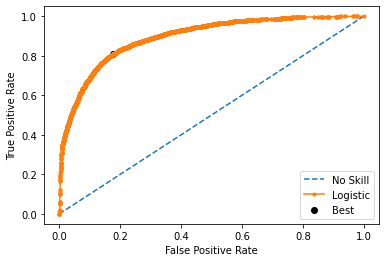

In [169]:
# predict probabilities
yhat = model_4.predict(X_train)

# keep probabilities for the positive outcome only
yhat = yhat[:, 0]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [170]:
y_pred_s = model_4.predict(X_val)
#Predicting the results using tuned threshold
y_pred_s = (y_pred_s >thresholds[ix])
y_pred_s

50/50 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [172]:
cr=classification_report(y_val,y_pred_s)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1274
           1       0.49      0.70      0.57       326

    accuracy                           0.79      1600
   macro avg       0.70      0.76      0.72      1600
weighted avg       0.83      0.79      0.80      1600



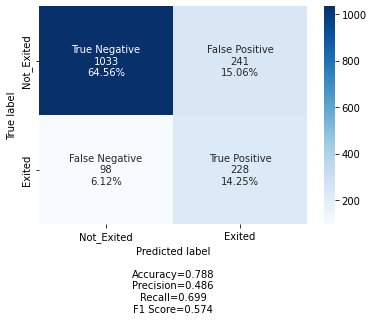

In [173]:
#Calculating the confusion matrix 
cm_s=confusion_matrix(y_val, y_pred_s)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm_s, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

As you can see, the accuracy and recall of the model increased when compared to previous models. Let's try Hyperparameter optimization just to see if we can increase the accuracy without the expense of Recall. 

In [ ]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [ ]:
def create_model_v2(dropout_rate=0.1,lr=0.001,layer_1=32,layer_2=16,layer_3=8):  
    np.random.seed(1337)
    model = Sequential()
    # This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
    model.add(Dense(layer_1,activation='relu',input_dim = X_train.shape[1]))
    #Lets use dropout to prevent the overfitting 
    model.add(Dropout(dropout_rate))
    # # Adding the hidden layer
    # Notice that we do not need to specify input dim. 
    model.add(Dense(layer_2,activation='relu'))
    # Adding dropout layer to prevent the overfitting
    model.add(Dropout(dropout_rate))
    model.add(Dense(layer_3,activation='relu'))
    # # Adding the output layer
    # Notice that we do not need to specify input dim. 
    # we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
    # We use the sigmoid because we want probability outcomes
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

##Using Grid search

We are using grid search to optimize three hyperparameters called **drop_out rate, batch size, epochs** due to the limited time. But you can optimize the other hyperparameters as mentioned above

In [ ]:
keras_estimator = KerasClassifier(build_fn=create_model_v2, verbose=1)

In [ ]:
# define the grid search parameters
param_grid = {
    'batch_size':[40, 64, 128],
    "lr":[0.01,0.001,0.1],
    "dropout_rate":[0.1,0.2,0.3],   
}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1)

In [ ]:
grid_result = grid.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   17.0s finished


204/204 [==============================] - 1s 2ms/step - loss: 0.5377 - accuracy: 0.7336 - val_loss: 0.6214 - val_accuracy: 0.6949
Best: 0.638434 using {'batch_size': 40, 'dropout_rate': 0.1, 'lr': 0.01}


* Best model is with the following configuration:  ( It may vary each time code runs )

**Result of Grid Search**

{'batch_size': 64, 'dropout': 0.1, 'learning_rate":0.01}

**Heuristic for Hyperparameters**

optimizer="adam", layer1_units=32, layer2_units = 16,layer3_units = 8

##Let's create the final model with above mentioned configuration

In [ ]:
estimator_v2=create_model_v2(dropout_rate=grid_result.best_params_['dropout_rate'],lr=grid_result.best_params_['lr'])
estimator_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                384       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-traina

In [ ]:
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=25)
mc_cb = ModelCheckpoint("model_1", monitor = "val_recall", save_best_only = True, verbose = 2, mode = "max")

history_h=estimator_v2.fit(X_train, y_train, epochs=100, batch_size = grid_result.best_params_['batch_size'], verbose=1,validation_split=0.2)

Epoch 1/100
204/204 [==============================] - 1s 2ms/step - loss: 0.5503 - accuracy: 0.7293 - val_loss: 0.6451 - val_accuracy: 0.6626
Epoch 2/100
204/204 [==============================] - 0s 2ms/step - loss: 0.5023 - accuracy: 0.7594 - val_loss: 0.5932 - val_accuracy: 0.5871
Epoch 3/100
204/204 [==============================] - 1s 3ms/step - loss: 0.4801 - accuracy: 0.7764 - val_loss: 0.6459 - val_accuracy: 0.6503
Epoch 4/100
204/204 [==============================] - 0s 2ms/step - loss: 0.4595 - accuracy: 0.7906 - val_loss: 0.5162 - val_accuracy: 0.7410
Epoch 5/100
204/204 [==============================] - 0s 2ms/step - loss: 0.4500 - accuracy: 0.7889 - val_loss: 0.5957 - val_accuracy: 0.6930
Epoch 6/100
204/204 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.8013 - val_loss: 0.5958 - val_accuracy: 0.6665
Epoch 7/100
204/204 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.8031 - val_loss: 0.5295 - val_accuracy: 0.7102

Epoch 58/100
204/204 [==============================] - 0s 1ms/step - loss: 0.3743 - accuracy: 0.8364 - val_loss: 0.4727 - val_accuracy: 0.7925
Epoch 59/100
204/204 [==============================] - 0s 1ms/step - loss: 0.3708 - accuracy: 0.8359 - val_loss: 0.4844 - val_accuracy: 0.7876
Epoch 60/100
204/204 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.8349 - val_loss: 0.4885 - val_accuracy: 0.7813
Epoch 61/100
204/204 [==============================] - 0s 1ms/step - loss: 0.3712 - accuracy: 0.8355 - val_loss: 0.4698 - val_accuracy: 0.7960
Epoch 62/100
204/204 [==============================] - 0s 1ms/step - loss: 0.3741 - accuracy: 0.8328 - val_loss: 0.5152 - val_accuracy: 0.7641
Epoch 63/100
204/204 [==============================] - 0s 2ms/step - loss: 0.3734 - accuracy: 0.8380 - val_loss: 0.5157 - val_accuracy: 0.7420
Epoch 64/100
204/204 [==============================] - 0s 2ms/step - loss: 0.3710 - accuracy: 0.8379 - val_loss: 0.4504 - val_accuracy:

Plotting the validation and training loss

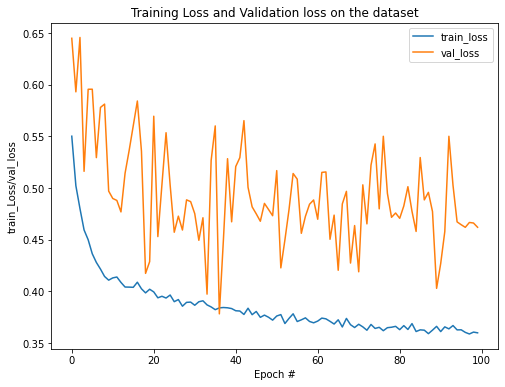

In [ ]:
N =100
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), history_h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_h.history["val_loss"], label="val_loss")

plt.title("Training Loss and Validation loss on the dataset")
plt.xlabel("Epoch #")
plt.ylabel("train_Loss/val_loss")
plt.legend(loc=0)
plt.show()

There is a lot of noise, and the model seems to overfit. 

### Finding the optimal threshold 

Best Threshold=0.334176, G-Mean=0.856


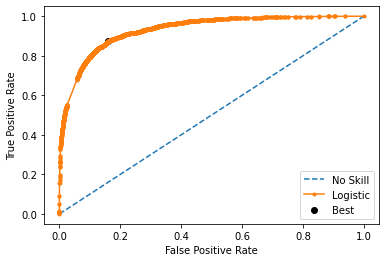

In [ ]:
# predict probabilities
yhat = estimator_v2.predict(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

#### Predict the results using best threshold 

In [ ]:
y_pred_h = estimator_v2.predict(X_val)
y_pred_h = (y_pred_h > thresholds[ix])
print(y_pred_h)

[[False]
 [False]
 [False]
 ...
 [False]
 [ True]
 [ True]]


#### Print the confusion matrix

In [ ]:
#lets print classification report
cr=metrics.classification_report(y_val,y_pred_h)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1274
           1       0.46      0.67      0.55       326

    accuracy                           0.77      1600
   macro avg       0.68      0.73      0.70      1600
weighted avg       0.81      0.77      0.79      1600



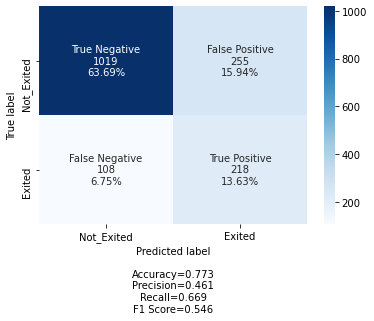

In [ ]:
#Calculating the confusion matrix 
cm_h=confusion_matrix(y_val, y_pred_h)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm_h, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

Oversampling using SMOTE did not help to improve the  Recall. 

Note: - ANN used on the synthesized data ( SMOTE ) was also working fine but we can not believe in this model because here we have generated the data artificially and this might also be the case that a particular data point generated in SMOTE might not make sense. Therefore, we really can not believe in a model trained on resampled data. We can try to use a cost-sensitive loss function in place of SMOTE.

Seems like this data will be overfitted when we try to apply more hyperparameter tuning and works fine for a simple model having two-three layers with a small dropout ratio. So, we can choose the Final model as  **model_3** which is using dropout and works on an imbalanced dataset. 

### Now let's predict the final model on the test data

319/319 [==============================] - 1s 2ms/step
Best Threshold=0.245034, G-Mean=0.810


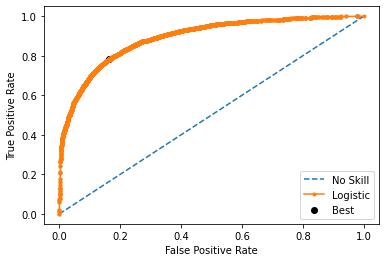

In [174]:
# predict probabilities
yhat = model_3.predict(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [175]:
y_pred_test = model_3.predict(X_test)
y_pred_h = (y_pred_test > thresholds[ix])
print(y_pred_test)

63/63 [==============================] - 0s 1ms/step
[[0.02910052]
 [0.16434151]
 [0.04222623]
 ...
 [0.76305646]
 [0.02337671]
 [0.14048614]]


In [177]:
#lets print classification report
cr=classification_report(y_test,y_pred_h)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1593
           1       0.52      0.75      0.61       407

    accuracy                           0.81      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.81      0.82      2000



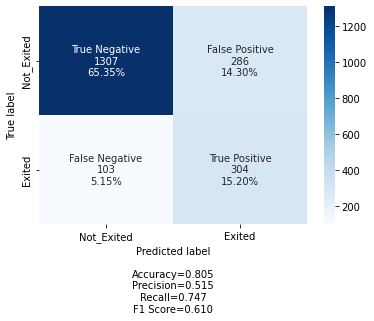

In [178]:
#Calculating the confusion matrix 
cm_h=confusion_matrix(y_test, y_pred_h)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm_h, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

# Using MLPClassifier

In [189]:
from sklearn.neural_network import MLPClassifier

model_nn = MLPClassifier(
    hidden_layer_sizes = (32, 16, 8),
    activation = "relu",
    solver = "adam",
    max_iter = 200,
    alpha = 0.1,
    early_stopping = True,
    n_iter_no_change = 5,
    random_state = 10
).fit(X_train, y_train)

pred_val = model_nn.predict(X_val)
pred_test = model_nn.predict(X_test)

In [190]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1274
           1       0.78      0.40      0.52       326

    accuracy                           0.85      1600
   macro avg       0.82      0.68      0.72      1600
weighted avg       0.85      0.85      0.83      1600



In [191]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.43      0.56       407

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



In [193]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(
    solver = "lbfgs",
    class_weight = "balanced",
    random_state = 10
).fit(X_train, y_train)

pred_val = model_log.predict(X_val)
pred_test = model_log.predict(X_test)

In [194]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1274
           1       0.37      0.67      0.48       326

    accuracy                           0.70      1600
   macro avg       0.63      0.69      0.64      1600
weighted avg       0.79      0.70      0.73      1600



In [195]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1593
           1       0.38      0.71      0.50       407

    accuracy                           0.71      2000
   macro avg       0.64      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000



In [199]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB().fit(X_train, y_train)

pred_val = model_nb.predict(X_val)
pred_test = model_nb.predict(X_test)

In [200]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1274
           1       0.67      0.36      0.46       326

    accuracy                           0.83      1600
   macro avg       0.76      0.66      0.68      1600
weighted avg       0.81      0.83      0.81      1600



In [201]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1593
           1       0.62      0.35      0.45       407

    accuracy                           0.82      2000
   macro avg       0.73      0.65      0.67      2000
weighted avg       0.80      0.82      0.80      2000



### **Conclusion:**

* The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review its target market or review the strategy for retention between the different age groups.

* About the tenure, the clients on either end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure. Worryingly, the bank is losing customers with significant bank balances which are likely to hit their available capital for lending.

* The proportion of female customers churning is also greater than that of male customers. 
Interestingly, the majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.


* Unsurprisingly the inactive members have a greater churn. 
Worryingly is that the overall proportion of inactive members is quite high suggesting that the bank may need a program implemented to turn this group into active customers as this will have a positive impact on the customer churn.



#### The optimised model gives better results as seen from the confusion matrix as well as improved accuracy.


We encourage the learners to further look for optimizing the model and come up with better results.

#### Happy Learning!